<a href="https://colab.research.google.com/github/tkg31302/Algo-trading/blob/main/Pairwise_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pairwise Strategy

In [19]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

N = 50
T = 60
P = 7
M = 4
R = 0.8
F = 0.005
B = 10000

In [20]:
def GetData(NameOfFile):
  return pd.DataFrame(pd.read_csv(NameOfFile, usecols = ['datadate','tic','adjcp']))

In [21]:
def PartitionData(Data):
  DateToIndex = {}
  for e in range(len(Data['datadate'])):
    DateToIndex.setdefault(str(Data['datadate'][e]),e)
  return [np.array_split(Data,2926), DateToIndex]

def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
  NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
  i = 0
  while i >= 0:
    x = str(NdaysAgo - datetime.timedelta(days = i)).replace('-','')
    if (x in DateToIndex.keys()):
      break
    i += 1
  temp = x
  Momentum = np.array(PartitionedDataFrameList[DateToIndex[today] % 2926]['adjcp']) - np.array(PartitionedDataFrameList[DateToIndex[temp] % 2926]['adjcp'])
  Sum = np.array(PartitionedDataFrameList[DateToIndex[today] % 2926]['adjcp'])
  for i in range((DateToIndex[temp] + 1), (DateToIndex[today]),30):
    Sum += np.array(PartitionedDataFrameList[i % 2926]['adjcp'])
  return Momentum * N / Sum

def GetBalanced(prices, weights, balance):
  copy = np.flip(np.sort(weights))
  for i in range(M,len(weights)):
    copy[i] = 0
  for i in range(len(weights)):
    if weights[i] not in copy:
      weights[i] = 0
    elif weights[i] < 0:
      weights[i] = 0
  sum = np.sum(weights)
  if (sum <= 0):
    return np.zeros(30, dtype = float)
  weights /= sum
  sum = np.sum(weights * prices)
  return (balance / sum) * weights

In [22]:
def Switch(firstStock, secondStock, today ,PartitionedDataFrames):
  weights = GetMomentumBasedPriority(PartitionedDataFrames, DateToIndex, today)
  if weights[firstStock] >= weights[secondStock]:
    return firstStock
  else:
    return secondStock

In [23]:
class PortFolio:
  def __init__(self, balance, numStocks, negCorr, prices):
    self.balance = balance
    self.numStocks = numStocks
    self.numStocks += GetBalanced(prices,GetMomentumBasedPriority(PartitionedData,DateToIndex,list(DateToIndex.keys())[T]),self.balance)
    self.prices = prices
    self.balance -= np.sum(self.numStocks * self.prices) * (1 + F)
    self.negCorr = negCorr

  def SellStock(self, index):
    self.balance += self.numStocks[index] * self.prices[index] * (1 - F)
    self.numStocks[index] = 0

  def BuyStock(self, index, number):
    self.balance -= number * self.prices[index] * (1 + F)

  def CalculateNetWorth(self):
    return self.balance + np.sum(self.numStocks * self.prices) * (1 - F)

  def ChangePricesTo(self, newPriceVector):
    self.prices = newPriceVector

  def ChangePairs(self):
    if self.negCorr == []:
      return
    for i in range(len(self.negCorr) - 1):
      x = Switch(self.negCorr[i][0],self.negCorr[i][1],today,PartitionedData)
      y = self.negCorr[i][0] + self.negCorr[i][1] - x
      credit = self.numStocks[y] * self.prices[y] * (1 - F)
      self.numStocks[y] = 0
      self.numStocks[x] += credit / (self.prices[x] * (1 + F))

  def RebalancePortfolio(self):
    TdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -T)
    i = 0
    while i >= 0:
      x = str(TdaysAgo - datetime.timedelta(days = i)).replace('-','')
      if (x in DateToIndex.keys()):
        break
      i += 1
    temp = x
    Sum = [np.array(PartitionedData[DateToIndex[today] % 2926]['adjcp'])]
    for i in range((DateToIndex[temp] + 1), (DateToIndex[today]),30):
      Sum.append(np.array(PartitionedData[i % 2926]['adjcp']))
    corrCoef = np.corrcoef(np.array(Sum))
    copy = np.sort(corrCoef.flatten())
    for k in range(M):
      for i in range(corrCoef.shape[0]):
        for j in range(30):
          if abs(corrCoef[i][j] - copy[k]) < 1e-10:
            self.negCorr.append((i,j))
    self.negCorr = self.negCorr[0:M]
    copy = self.negCorr.copy()
    if self.negCorr == []:
      return
    for i in range(len(self.negCorr) - 1):
      for j in range(i + 1, len(self.negCorr)):
        x = list(self.negCorr[i])
        y = list(self.negCorr[j])
        if x[0] == y[0] or x[0] == y[1] or x[1] == y[0] or x[1] == y[1]:
          if self.negCorr[j] in copy and copy.count(self.negCorr[j]) > 1:
            copy.remove(self.negCorr[j])
    self.negCorr = copy.copy()
    self.ChangePairs()

In [25]:
Data = GetData("DATA.csv")
List = PartitionData(Data)
PartitionedData = List[0]
DateToIndex = List[1]

myPortfolio = PortFolio(B * R,np.zeros(30, dtype = float),[],np.array(PartitionedData[int(list(DateToIndex.keys())[T]) % 2926]['adjcp']))
NetWorthAfterEachTrade = [myPortfolio.CalculateNetWorth() + B * (1 - R)]

for i in range((T + 1),len(PartitionedData)):
  today = list(DateToIndex.keys())[i]
  myPortfolio.ChangePricesTo(np.array(PartitionedData[int(today) % 2926]['adjcp']))
  NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth() + B * (1 - R))
  if (i % T == 0):
    myPortfolio.RebalancePortfolio()
  if (i % P == 0):
    myPortfolio.ChangePairs()

In [26]:
def VisualizeData(FinalData):
  plt.plot(FinalData)
  plt.show()

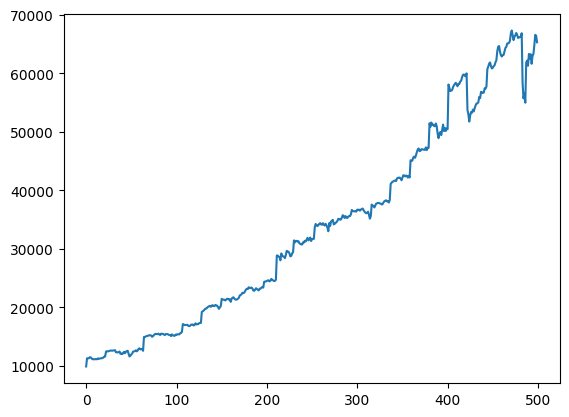

In [28]:
VisualizeData(NetWorthAfterEachTrade[:500])